# xarray_explore.ipynb

## Purpose
Explore the xarray package, especially application to reading NetCDF climate model output and performing basic analysis.

## Background
Previously, I have:
1. Performed basic post-processing and analysis using [Climate Data Operators (CDO)](https://code.zmaw.de/projects/cdo), although I have recently started delaying most of the analysis until after the data have been read into Python.
1. Read the NetCDF data into Python numpy arrays using Scientific.IO.NetCDF or, more recently, netCDF4.
1. Performed analysis on the numpy arrays.
1. Used matplotlib, with basemap, to visualise the resulting numpy arrays.

Having recently learned some basic pandas, I understand that the "labelled array" features of xarray could bring advantages when it comes to reading and analysing the data (2nd and 3rd steps above). So I thought it would be beneficial to explore the xarray package.

## History
- 2017-04-03 - Benjamin S. Grandey (benjamin@smart.mit.edu).
- 2017-05-04 - Updating to use climapy.xr_shift_lon().

In [1]:
import climapy
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

## Required data
In order to explore xarray, I will use NetCDF data files from [*Data for "Radiative effects of interannually varying vs. interannually invariant aerosol emissions from fires"* (doi: 10.6084/m9.figshare.3497705.v5)](https://doi.org/10.6084/m9.figshare.3497705.v5).

In [2]:
# Location of gunzipped input data - CHANGE IF NECESSARY
in_dir = '/Users/grandey/data/figshare/figshare3497705v5/'

## Reading a single NetCDF file
Ref: http://xarray.pydata.org/en/stable/io.html#netcdf

In [3]:
# Open a single file as an xarray Dataset
ds_bb0 = xr.open_dataset(in_dir+'bb0_o2000.nc', decode_times=False)
print(ds_bb0)
# Close the dataset
ds_bb0.close()

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 96, lon: 144, time: 504)
Coordinates:
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 ...
  * time        (time) float64 761.0 789.0 820.0 850.0 881.0 911.0 942.0 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) float64 730.0 761.0 761.0 789.0 789.0 820.0 ...
    AEROD_v     (time, lat, lon) float64 0.002776 0.002776 0.002776 0.002776 ...
    CLDHGH      (time, lat, lon) float32 0.274275 0.274275 0.274275 0.274275 ...
    CLDLOW      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    CLDMED      (time, lat, lon) float32 0.458974 0.458974 0.458974 0.458974 ...
    CLDTOT      (time, lat, lon) float32 0.519312 0.519312 0.519312 0.519312 ...
    PRECC       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PRECL       (time, lat, lon) float32 5.34166e-10 5.34166e-10 5

## Reading multiple NetCDF files
Refs: http://xarray.pydata.org/en/stable/dask.html#reading-and-writing-data,
xr.open_mfdataset documentation, and pd.Index documentation.

In [4]:
# List of filenames to open
filenames = glob(in_dir+'bb[12]???_o2000.nc')  # select files with 144 timesteps
# Index of experiment codes for creation of a dimension across which to concatenate
exp_index = pd.Index([s.split('/')[-1][:-9] for s in filenames], name='exp')
# Open multiple files as a single dataset
ds_multiple = xr.open_mfdataset(filenames, decode_times=False, concat_dim=exp_index)
print(ds_multiple)
# Don't yet close - this dataset will be used below

<xarray.Dataset>
Dimensions:     (bnds: 2, exp: 10, lat: 96, lon: 144, time: 144)
Coordinates:
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 ...
  * time        (time) float64 761.0 789.0 820.0 850.0 881.0 911.0 942.0 ...
  * exp         (exp) object 'bb1997' 'bb1998' 'bb1999' 'bb2000' 'bb2001' ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (exp, time, bnds) float64 730.0 761.0 761.0 789.0 789.0 ...
    AEROD_v     (exp, time, lat, lon) float64 0.00353 0.00353 0.00353 ...
    CLDHGH      (exp, time, lat, lon) float32 0.291252 0.291252 0.291252 ...
    CLDLOW      (exp, time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    CLDMED      (exp, time, lat, lon) float32 0.365796 0.365796 0.365796 ...
    CLDTOT      (exp, time, lat, lon) float32 0.431261 0.431261 0.431261 ...
    PRECC       (exp, time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P

## Basic examples of Dataset and DataArray operations
Refs: http://xarray.pydata.org/en/stable/examples/quick-overview.html, http://xarray.pydata.org/en/stable/indexing.html, 

In [5]:
# Select temperature DataArray
data = ds_multiple['TS']
data  # note: currently contains a dask array, since open_mfdataset was used

<xarray.DataArray 'TS' (exp: 10, time: 144, lat: 96, lon: 144)>
dask.array<concatenate, shape=(10, 144, 96, 144), dtype=float32, chunksize=(1, 144, 96, 144)>
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * time     (time) float64 761.0 789.0 820.0 850.0 881.0 911.0 942.0 973.0 ...
  * exp      (exp) object 'bb1997' 'bb1998' 'bb1999' 'bb2000' 'bb2001' ...
Attributes:
    long_name:     Surface temperature (radiative)
    units:         K
    cell_methods:  time: mean

In [6]:
# Indexing and selecting data in DataArrays
# Method 1: positional and by index, like numpy
temp1 = data[0, 0:2, 0:3, 0:4]  # order of dims: exp, time, lat, lon
# Method 2: positional and by coordinate label, like pandas
temp2 = data.loc['bb1997', 760.:790., -90.:-85., 0.:8.]
# Method 3: by dimension name and integer label
temp3 = data.isel(exp=0, time=slice(2), lat=slice(3), lon=slice(4))
# Method 4: by dimension name and coordinate label
temp4 = data.sel(exp='bb1997', time=slice(760., 790.), lat=slice(-90., -85.), lon=slice(0., 8.))
# If all equal, then print
if temp1.equals(temp2) and temp1.equals(temp3) and temp1.equals(temp4):
    print(temp1)
else:
    print('Not all equal!')

<xarray.DataArray 'TS' (time: 2, lat: 3, lon: 4)>
dask.array<getitem, shape=(2, 3, 4), dtype=float32, chunksize=(2, 3, 4)>
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5
  * lat      (lat) float64 -90.0 -88.11 -86.21
  * time     (time) float64 761.0 789.0
    exp      <U6 'bb1997'
Attributes:
    long_name:     Surface temperature (radiative)
    units:         K
    cell_methods:  time: mean


In [7]:
# Indexing and selecting Datasets
# The 3rd and 4th methods above (ie by dimension name) work on Datasets
temp5 = ds_multiple.isel(exp=0, time=slice(2), lat=slice(3), lon=slice(4))
temp6 = ds_multiple.sel(exp='bb1997', time=slice(760., 790.), lat=slice(-90., -85.), lon=slice(0., 8.))
# If equal and if consistent with temp1 above, then print
if temp5.equals(temp6) and temp5['TS'].equals(temp1):
    print(temp5)
else:
    print('Not equal/consistent!')

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 3, lon: 4, time: 2)
Coordinates:
  * lon         (lon) float64 0.0 2.5 5.0 7.5
  * lat         (lat) float64 -90.0 -88.11 -86.21
  * time        (time) float64 761.0 789.0
    exp         <U6 'bb1997'
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) float64 730.0 761.0 761.0 789.0
    AEROD_v     (time, lat, lon) float64 0.00353 0.00353 0.00353 0.00353 ...
    CLDHGH      (time, lat, lon) float32 0.291252 0.291252 0.291252 0.291252 ...
    CLDLOW      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    CLDMED      (time, lat, lon) float32 0.365796 0.365796 0.365796 0.365796 ...
    CLDTOT      (time, lat, lon) float32 0.431261 0.431261 0.431261 0.431261 ...
    PRECC       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PRECL       (time, lat, lon) float32 2.18683e-10 2.18683e-10 2.18683e-10 ...
    TS          (time, lat, lon) float32 238.278 238.205 240.09 238.283 ...
  

In [8]:
# Examples of computation
temp = data + 273.15
temp = np.sqrt(data)
temp = data.T
temp = data.mean()
temp = data.mean(dim='exp')  # ensemble mean
temp = data.mean(dim=['exp', 'time'])  # mean across ensemble and time
print(temp)
print(temp.load())  # load method used to convert from dask array to numpy array

<xarray.DataArray 'TS' (lat: 96, lon: 144)>
dask.array<mean_agg-aggregate, shape=(96, 144), dtype=float32, chunksize=(96, 144)>
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
<xarray.DataArray 'TS' (lat: 96, lon: 144)>
array([[ 220.603683,  220.582642,  220.584045, ...,  220.588776,  220.576324,
         220.608261],
       [ 220.881836,  220.726807,  220.523895, ...,  221.615891,  221.522064,
         221.160706],
       [ 220.099152,  219.940796,  219.847855, ...,  220.895599,  220.621674,
         220.362137],
       ..., 
       [ 253.746567,  253.857529,  253.957901, ...,  253.272614,  253.44249 ,
         253.606354],
       [ 252.545578,  252.579041,  252.588776, ...,  252.329987,  252.400558,
         252.469635],
       [ 251.724289,  251.727554,  251.732025, ...,  251.713089,  251.71727 ,
         251.720383]], dtype=float32)
Coordinates:
  * lon      (lon

In [9]:
# Close Dataset
ds_multiple.close()

**Other things to be aware of:**
- Automatic broadcasting is based on dimension name.
- The "groupby" method is similar to pandas.
- xarray objects can be converted to pandas objects and vice versa.
- The "to_netcdf" method allows writing to NetCDF files.

## Reproduce simplified version of Fig. 6b of [Grandey et al. (2016)](http://dx.doi.org/10.5194/acp-16-14495-2016)
The analysis leading to all the figures (including Fig. 6b) of [Grandey et al. (2016)](http://dx.doi.org/10.5194/acp-16-14495-2016) relied heavily on both CDO and numpy. Here, I will instead use xarray to produce a simplified version of Fig. 6b. For current purposes, I will not apply significance testing.

In [10]:
# Load data for simulation "F0"
ds_f0 = xr.open_dataset(in_dir+'bb0_o2000.nc', decode_times=False)

In [11]:
# Load data for the "F{yyyy}" ensemble
filenames = glob(in_dir+'bb[12]???_o2000.nc')
exp_index = pd.Index([s.split('/')[-1][:-9] for s in filenames], name='exp')
ds_fyyyy = xr.open_mfdataset(filenames, decode_times=False, concat_dim=exp_index)  # same as ds_multiple above

In [12]:
# Calculate mean across time and, for "F{yyyy}", the ensemble
# Note: two year "spin-up" period has already been excluded from the input data.
# Note: if significance were to be tested, as per the original Fig. 6b, then annual means
#   for each ensemble member would be required. For current purposes, I am skipping this.
ds_f0 = ds_f0.mean(dim='time')
ds_fyyyy = ds_fyyyy.mean(dim=['time', 'exp'])

In [13]:
# Calculate the F{yyyy}-F0 difference
ds_diff = ds_fyyyy - ds_f0

In [14]:
# Select net RFP
data = ds_diff['cFNTOA']
data

<xarray.DataArray 'cFNTOA' (lat: 96, lon: 144)>
dask.array<sub, shape=(96, 144), dtype=float64, chunksize=(96, 144)>
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...

In [15]:
# Shift longitudes by approx -180deg
data = climapy.xr_shift_lon(data, lon_min=-180.)
data

<xarray.DataArray 'cFNTOA' (lat: 96, lon: 144)>
dask.array<rechunk-merge, shape=(96, 144), dtype=float64, chunksize=(96, 144)>
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...

/Users/grandey/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:682: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  using_corners = (None not in [llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat])


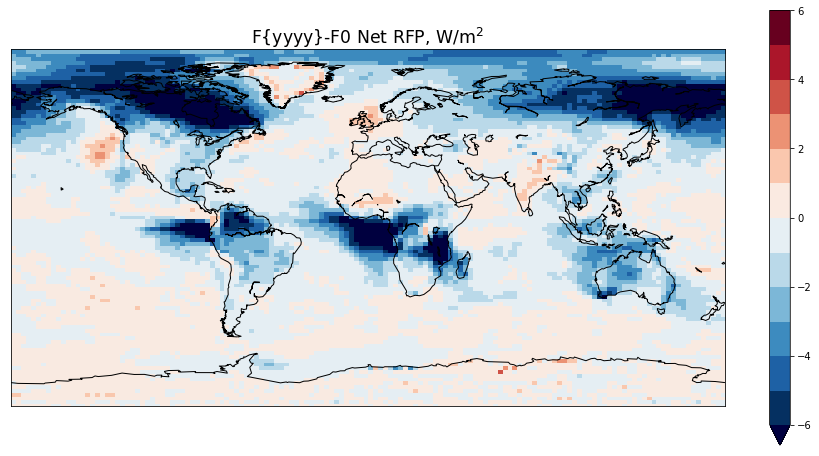

In [16]:
# Plot simplified figure
fig = plt.figure(figsize=(16, 8))
# Lower bound for first longitude bin (important for map)
lon0 = (data['lon'][0] - (data['lon'][1]-data['lon'][0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (data['lat'][0] - (data['lat'][1]-data['lat'][0])/2.0).values
# Map
bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0)
bm.drawcoastlines()
# Color map
cmap = plt.cm.get_cmap('RdBu_r', 12)
cmap.set_under([0, 0, 0.25])
cmap.set_over([0.25, 0, 0])
# Plot data using imshow
plt.imshow(np.flipud(data),
           extent=[lon0, 360+lon0, lat0, -lat0],
           interpolation='Nearest', cmap=cmap, vmin=-6, vmax=6)
# Colorbar
plt.colorbar(extend='min')
# Title
plt.title('F{yyyy}-F0 Net RFP, W/m$^2$', fontsize='xx-large')
plt.show()

Caption: Net (shortwave plus longwave) top-of-atmosphere radiative flux perturbation (RFP) for the {Fyyyy} ensemble relative to simulation F0. This is a simplified version of Fig. 6b of [*"Radiative effects of interannually varying vs. interannually invariant aerosol emissions from fires"*, doi:10.5194/acp-16-14495-2016](http://dx.doi.org/10.5194/acp-16-14495-2016)